In [2]:
import pandas as pd
import cv2
import numpy as np

import matplotlib.pyplot as plt

deg_to_rad = np.pi/180

In [3]:
df = pd.read_csv("cell_metrics_VISp.csv")

In [4]:
id_cols = [
    "experiment_container_id", "cell_specimen_id"
]

sg_cols = [
    "pref_ori_sg", "pref_sf_sg", "pref_phase_sg"
]

dg_cols = [
    "pref_dir_dg", "pref_tf_dg"
]

In [5]:
df = df[df["failed_experiment_container"]=="f"]
len(df)

63251

### Sample Image

In [51]:
im = cv2.imread("sample_image.jpeg")

In [52]:
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

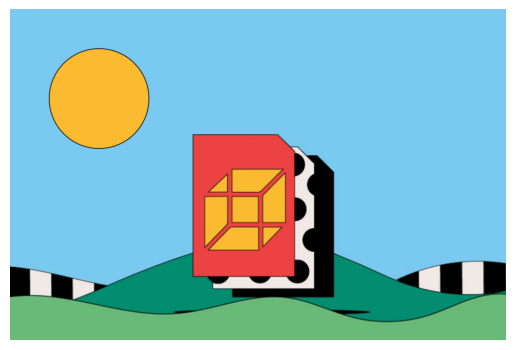

In [53]:
plt.imshow(im[:,:,::-1])
plt.axis('off')
plt.show()

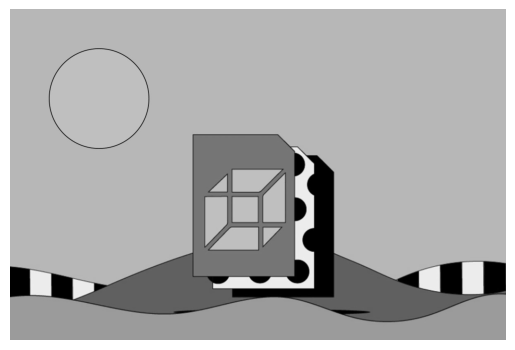

In [54]:
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.show()

### Sample Static Filters

In [55]:
df_sg = df[id_cols+sg_cols].dropna()

len(df_sg)

30997

In [56]:
df_sg

,experiment_container_id,cell_specimen_id,pref_ori_sg,pref_sf_sg,pref_phase_sg
6,511498742,517397361,150.0,0.08,0.50
8,511498742,517397369,30.0,0.08,0.00
10,511498742,517397377,30.0,0.08,0.00
11,511498742,517397381,120.0,0.32,0.25
12,511498742,517397385,90.0,0.02,0.25
...,...,...,...,...,...
63239,712178509,738948929,60.0,0.04,0.25
63240,712178509,738949054,30.0,0.16,0.25
63242,712178509,738949127,150.0,0.08,0.75
63245,712178509,738949207,60.0,0.04,0.75


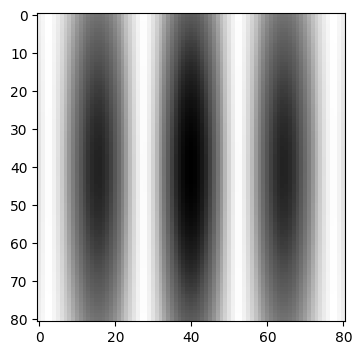

In [153]:
ori = 0
sf = 0.02
phase = 0.0

g = cv2.getGaborKernel(
    ksize=(80,80),
    sigma=1/sf, # 50
    theta=ori*deg_to_rad,
    lambd=1/sf,
    gamma=1, # 1
    psi=phase*2*np.pi, 
)

plt.figure(figsize=(5, 4))
plt.imshow(abs(g), cmap='Greys')
plt.show()

In [155]:
im_conv = cv2.filter2D(
    im_gray,
    ddepth=-1,
    kernel=cv2.flip(g,-1),
    borderType=cv2.BORDER_CONSTANT
)

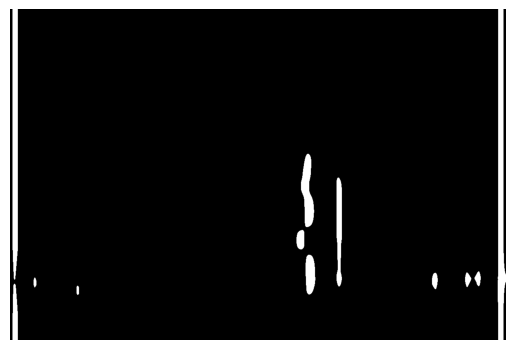

In [156]:
plt.imshow(im_conv, cmap='gray')
plt.axis('off')
plt.show()

In [157]:
import scipy

In [158]:
im_conv_scipy = scipy.ndimage.convolve(
    im_gray,
    g,
    mode='constant',
    cval=0.0,
)

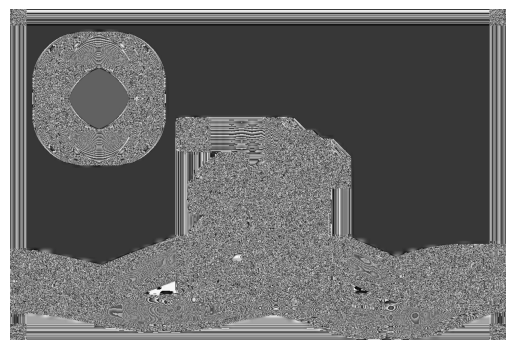

In [159]:
plt.imshow(im_conv_scipy, cmap='gray')
plt.axis('off')
plt.show()

In [184]:
def convolution2d(image, kernel):
    kernel = cv2.flip(kernel,-1)
    m, n = kernel.shape
    if (m == n):
        y, x = image.shape
        y = y - m + 1
        x = x - m + 1
        new_image = np.zeros((y,x))
        for i in range(y):
            for j in range(x):
                new_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel)
    return new_image

In [185]:
im_conv2 = convolution2d(im_gray, g)

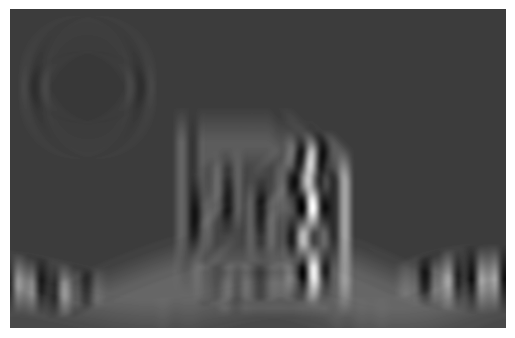

In [183]:
plt.imshow(im_conv2, cmap='gray')
plt.axis('off')
plt.show()

### Sample Dynamic Filters

In [8]:
df_dg = df[id_cols+dg_cols].dropna()

len(df_dg)

29635

In [9]:
frames_per_s = 60

In [10]:
spat_freq = 0.08
temp_freq = 4
orientation = 0 # true values are 0, 45, 90, 135, 180, 225, 270, 315

In [11]:
gs = [
    cv2.getGaborKernel(
        ksize=(80,80),
        sigma=40,
        theta=orientation*deg_to_rad,
        lambd=1/spat_freq,
        gamma=1,
        psi=i*2*np.pi,
    )
    for i in np.linspace(0, 1, int(frames_per_s/temp_freq))
]